In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
import cartopy.feature as cpf 
import xarray as xr
import utide
import pandas as pd
from matplotlib.dates import date2num
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.path as mpath
import matplotlib.ticker as mticker

Testing the waterlevel differences on boundary w.r.t boundary conditions.

In [6]:
#reading the his model file.
moddata=xr.open_dataset('../model_runs/cartesius_runs/test_boundary_runs/output/canada_model_0000_his.nc')
# moddata=xr.open_dataset('../model_runs/trial_run_dividedboundary/output/canada_model_0000_his.nc')
# moddata.info()
timemod=moddata.time.values[:]
modlon=moddata.station_x_coordinate.values[:] #0:78 for coarse #0:245 fine
modlat=moddata.station_y_coordinate.values[:]
name=moddata.station_name.values[:]
hmod=moddata.waterlevel.values[:,:475]
print(timemod)
print(timemod.shape)
print(hmod.shape)
moddata.close()

['2012-12-25T00:00:00.000000000' '2012-12-25T00:10:00.000000000'
 '2012-12-25T00:20:00.000000000' ... '2013-01-31T23:40:00.000000000'
 '2013-01-31T23:50:00.000000000' '2013-02-01T00:00:00.000000000']
(5473,)
(5473, 475)


In [16]:
#reading fes data
# fesdata=xr.open_dataset('../FESCanada/fesboundary_obs.nc')
# fesdata=xr.open_dataset('../FESCanada/oldboundary/boundary_obs_fes.nc')
fesdata=xr.open_dataset('../FESCanada/fes10km_5e-2_obs.nc')
timfes=fesdata.time.values
feslon=fesdata.lon.values
feslat=fesdata.lat.values
hfes=fesdata.tide.values
print(timfes)
print(timfes.shape)
print(hfes.shape)
fesdata.close()

['2012-12-25T00:00:00.000000000' '2012-12-25T00:10:00.000000000'
 '2012-12-25T00:20:00.000000000' ... '2013-01-31T23:40:00.000000000'
 '2013-01-31T23:50:00.000000000' '2013-02-01T00:00:00.000000000']
(5473,)
(5473, 475)


In [ ]:
#reading gtsm data
gtsmdata=xr.open_dataset('../gtsm_runs/Jan_standard_model/modelrunsdata/gtsm_model_his_201201.nc')
timegtsm=gtsmdata.time.values[:]
gtsmlon=gtsmdata.station_x_coordinate.values[0:77]
gtsmlat=gtsmdata.station_y_coordinate.values[0:77]
gtsmname=gtsmdata.station_name.values
hgtsm=gtsmdata.waterlevel.values[:,0:77]
print(timegtsm)
print(hgtsm.shape)

In [17]:
i=1
fig=plt.figure()
print(feslon[i],feslat[i])
print(gtsmlon[i],gtsmlat[i])
plt.plot(hgtsm[:,i],label='gtsm')
plt.plot(hfes[:,i],label='fes')
plt.legend()

-59.196217 50.330624


NameError: name 'gtsmlon' is not defined

<Figure size 432x288 with 0 Axes>

-56.07414 50.385624
-56.07414 50.390625


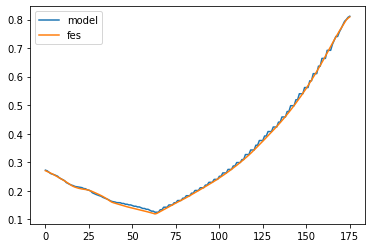

In [22]:
j=144*8
i=22;k=198
fig=plt.figure()
print(feslon[i],feslat[i])
print(modlon[i],modlat[i])
plt.plot(hmod[j,i:k],label='model')
plt.plot(hfes[j,i:k],label='fes')
plt.legend()
fig.savefig('waterlevel_boundary_'+str(j)+'.jpg',dpi=500)

-66.127686 83.20812
-66.127686 83.203125


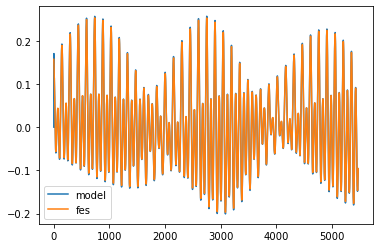

In [33]:
i=220
fig=plt.figure()
print(feslon[i],feslat[i])
print(modlon[i],modlat[i])
plt.plot(hmod[:,i],label='model')
plt.plot(hfes[:,i],label='fes')
plt.legend()
# fig.savefig('waterlevel_pt_'+str(i)+'.jpg',dpi=500)

In [ ]:
#function to compute M_2 amplitude and phase for all the stations given the station lon lat, 
#ssh and time. Here we use U tide solve function. Please note that some stations are on land as per 
# gtsm so they are ignored and an updated station lon lat file is obtained. 

def computetidal(ssh,time,station,StationLat,StationLon,const,epoch1,tidalconst):
    amp=[]
    ph=[]
    count=0
    Upstlon=[];Upstlat=[]
#     epoch1="201212250000"
    for i in range(len(station)):
        sshi=np.array(ssh[:,i])
        sumsshi=np.sum(sshi)
        is_empty = sshi.size == 0
        if (is_empty==False and pd.isna(sumsshi)==False):              
            coef = utide.solve(time,sshi ,
                                 lat=StationLat[i],
                                 epoch=epoch1,
                                 constit=const,
                                 conf_int='linear',
                                 white=True,
                                 method='ols')
            Amp=coef['A']
            Ph=coef['g']
            name=coef['name']
            j=np.where(name==tidalconst)
            amp=np.append(amp,Amp[j]) # 0 is for M2
            ph=np.append(ph,Ph[j])
            Upstlon=np.append(Upstlon,StationLon[i])
            Upstlat=np.append(Upstlat,StationLat[i])
    return(amp,ph,Upstlon,Upstlat)

In [ ]:
const=['K1','O1','Q1', 'P1','N2','M2','S2','K2']
tidalconst='M2'
epoch1='1970-01-01'
time=np.array(date2num(timemod))
M2amp,M2ph,UMlon,UMlat=computetidal(hmod,time,name,modlat,modlon,const,epoch1,tidalconst)

In [ ]:
const=['K1','O1','Q1', 'P1','N2','M2','S2','K2']
tidalconst='M2'
epoch1='1970-01-01'
time=np.array(date2num(timemod))
FM2amp,FM2ph,UFlon,UFlat=computetidal(hfes,time,name,modlat,modlon,const,epoch1,tidalconst)

In [ ]:
def interpol2grid(Mamp,Mph,Mlon,Mlat,Oamp,Oph,Olon,Olat):
	# points=np.vstack((Mlon,Mlat))
	# IMamp=interpolate.griddata(points.T,Mamp,(Olon,Olat),method='nearest')
	# IMph=interpolate.griddata(points.T,Mph,(Olon,Olat),method='nearest')
	# # TOM2ampmean,TOM2phmean,TStlon,TStlat
	UMlon=[];UMlat=[];IMamp=[];IMph=[]
	delindex=[]
	for i in range(len(Olon)):
	    x=Olon[i];y=Olat[i]
	    # print(x,y)
# #     for j in range(len(KPM2amp)):
# #         kpx=Stlon[j];kpy=Stlat[j]
	    commonx=np.isclose(Mlon,x,rtol=1e-3 )
	    commony=np.isclose(Mlat,y,rtol=1e-3)
	    trueindexx=np.where(commonx==True)
	    trueindexy=np.where(commony==True)
	    index=(np.intersect1d(trueindexx,trueindexy))
	    if len(index)==0:
	    	delindex=np.append(delindex,i)
	    	continue
	    elif len(index)>1:
	    	index=int(index[0])
	    else:
	    	index=int(index)
	    print(Mlon[index],Mlat[index])
	    print(x,y)
	    UMlon=np.append(UMlon,Mlon[index])
	    UMlat=np.append(UMlat,Mlat[index])
	    IMamp=np.append(IMamp,Mamp[index])
	    IMph=np.append(IMph,Mph[index])
	print(len(UMlon))
	Olon=np.delete(Olon,delindex.astype(int))
	Olat=np.delete(Olat,delindex.astype(int))
	Oamp=np.delete(Oamp,delindex.astype(int))
	Oph=np.delete(Oph,delindex.astype(int))
	return(IMamp,IMph,Oamp,Oph,Olon,Olat)

In [ ]:
(IMamp,IMph,Oamp,Oph,Olon,Olat)=interpol2grid(M2amp,M2ph,UMlon,UMlat,FM2amp,FM2ph,UFlon,UFlat)

In [ ]:
diffam=IMamp-Oamp
diffph=IMph-Oph

In [ ]:
plt.plot(diffam[60:])

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cpf 
   
# marking the x-axis and y-axis 
fig=plt.figure(figsize=(8,8), frameon=True)
ax=plt.axes(projection=ccrs.NorthPolarStereo()) 
# ax.set_extent([-160,-40,45,82], crs=ccrs.PlateCarree()) 
# ax.set_extent([-180,180,45,90], crs=ccrs.PlateCarree())  
feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='#e6e1e1',alpha=1)
ax.add_feature(feature) 
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
# theta = np.linspace(0, 2*np.pi, 100)
# center, radius = [0.5, 0.5], 0.5
# verts = np.vstack([np.sin(theta), np.cos(theta)]).T
# circle = mpath.Path(verts * radius + center)
# ax.set_boundary(circle, transform=ax.transAxes)
gl=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=0.5,alpha=0.2)
cont=plt.scatter(Olon,Olat,c=diffam,transform=ccrs.PlateCarree(),cmap='seismic',vmin=-0.5,vmax=0.5)
cbar=fig.colorbar(cont)
cbarlabel='Difference in Amplitude (Model-FES)(m)'
cbar.set_label(cbarlabel,rotation=90)
# plt.show()

In [ ]:
ndiffam=diffam[~np.isnan(diffam)]
diffph=diffph[~np.isnan(diffam)]
Olon=Olon[~np.isnan(diffam)]
Olat=Olat[~np.isnan(diffam)]
diffamrms = np.sqrt(np.mean(ndiffam**2))
fig=plt.figure(figsize=(14, 14))
cmap='seismic'
#     level=np.linspace(0,1.5,25) for contours 
level=0.5  #for scatter
# title='M2amp'
cbarlabel='Amplitude(m)'
ax=fig.add_subplot(1,2,1,projection=ccrs.NorthPolarStereo(central_longitude=0.0,true_scale_latitude=None, globe=None)) 
ax.set_extent((-158, -47, 49, 84), crs=ccrs.PlateCarree())
feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='black',alpha=1,edgecolor='none')
ax.add_feature(feature)
# ax.stock_img()
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
# theta = np.linspace(0, 2*np.pi, 100)
# center, radius = [0.5, 0.5], 0.5
# verts = np.vstack([np.sin(theta), np.cos(theta)]).T
# circle = mpath.Path(verts * radius + center)
# ax.set_boundary(circle, transform=ax.transAxes)
# gl=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=0.5,alpha=0.2)
cont=plt.scatter(Olon,Olat,c=ndiffam,cmap=cmap,vmin=-0.5,vmax=level,transform=ccrs.PlateCarree())
cbar=fig.colorbar(cont,fraction=0.078, pad=0.04)
cbar.set_label(cbarlabel, rotation=90) 
# ax.set_title(title)
#     level=np.linspace(0,360,10) for contours
level=50.
# title='M2ph'
cbarlabel='Phase(deg)'
ax=fig.add_subplot(1,2,2,projection=ccrs.NorthPolarStereo(central_longitude=0.0,true_scale_latitude=None, globe=None)) 
ax.set_extent((-158, -47, 49, 84), crs=ccrs.PlateCarree())
feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='black',alpha=1,edgecolor='none')
ax.add_feature(feature)
# ax.stock_img()
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
# theta = np.linspace(0, 2*np.pi, 100)
# center, radius = [0.5, 0.5], 0.5
# verts = np.vstack([np.sin(theta), np.cos(theta)]).T
# circle = mpath.Path(verts * radius + center)
# ax.set_boundary(circle, transform=ax.transAxes)
# gl=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=0.5,alpha=0.5)
cont=plt.scatter(Olon,Olat,c=diffph,cmap=cmap,vmin=-360,vmax=360,transform=ccrs.PlateCarree())
cbar=fig.colorbar(cont,fraction=0.078, pad=0.04)
cbar.set_label(cbarlabel, rotation=90) 
# ax.set_title(title)
fname='Model-FES'
fig.suptitle('Difference of M2 amp and phase ('+fname+' ) RMSE:'+'%.4f' % diffamrms+'m', fontsize=16)
fig.savefig(fname+'.jpg')

In [ ]:
gtsmstand='../../Modelling_bottom_friction/gtsm4.1/sim_cartesius/1.25Arcticgrid/gtsm4.1_newupdate/gtsmstandard/modelrunsdata/gtsm_model_his_201201.nc'
# moddata.info()
gtsmdata=xr.open_dataset(gtsmstand)
timegtsm=gtsmdata.time.values[7*24:-1]
gtsmlon=gtsmdata.station_x_coordinate.values
gtsmlat=gtsmdata.station_y_coordinate.values
name=gtsmdata.station_name.values
hgtsm=gtsmdata.waterlevel.values[7*24:-1,:]
print(timegtsm)
print(timegtsm.shape)
gtsmdata.close()

In [ ]:
const=['K1','O1','Q1', 'P1','N2','M2','S2','K2']
tidalconst='M2'
epoch1='1970-01-01'
timeg=np.array(date2num(timegtsm))
M2amp,M2ph,UMlon,UMlat=computetidal(hgtsm,timeg,name,gtsmlat,gtsmlon,const,epoch1,tidalconst)

In [ ]:
(GMamp,GMph,Oamp,Oph,Olon,Olat)=interpol2grid(M2amp,M2ph,UMlon,UMlat,FM2amp,FM2ph,UFlon,UFlat)

In [ ]:
diffamg=GMamp-Oamp
diffphg=GMph-Oph

In [ ]:
ndiffam=diffamg[~np.isnan(diffamg)]
diffph=diffphg[~np.isnan(diffamg)]
Olon=Olon[~np.isnan(diffamg)]
Olat=Olat[~np.isnan(diffamg)]
diffamgrms = np.sqrt(np.mean(ndiffam**2))
fig=plt.figure(figsize=(14, 14))
cmap='seismic'
#     level=np.linspace(0,1.5,25) for contours 
level=0.5  #for scatter
# title='M2amp'
cbarlabel='Amplitude(m)'
ax=fig.add_subplot(1,2,1,projection=ccrs.NorthPolarStereo(central_longitude=0.0,true_scale_latitude=None, globe=None)) 
ax.set_extent((-158, -47, 49, 84), crs=ccrs.PlateCarree())
feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='black',alpha=1,edgecolor='none')
ax.add_feature(feature)
# ax.stock_img()
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
# theta = np.linspace(0, 2*np.pi, 100)
# center, radius = [0.5, 0.5], 0.5
# verts = np.vstack([np.sin(theta), np.cos(theta)]).T
# circle = mpath.Path(verts * radius + center)
# ax.set_boundary(circle, transform=ax.transAxes)
# gl=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=0.5,alpha=0.2)
cont=plt.scatter(Olon,Olat,c=ndiffam,cmap=cmap,vmin=-0.5,vmax=level,transform=ccrs.PlateCarree())
cbar=fig.colorbar(cont,fraction=0.078, pad=0.04)
cbar.set_label(cbarlabel, rotation=90) 
# ax.set_title(title)
#     level=np.linspace(0,360,10) for contours
level=50.
# title='M2ph'
cbarlabel='Phase(deg)'
ax=fig.add_subplot(1,2,2,projection=ccrs.NorthPolarStereo(central_longitude=0.0,true_scale_latitude=None, globe=None)) 
ax.set_extent((-158, -47, 49, 84), crs=ccrs.PlateCarree())
feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='black',alpha=1,edgecolor='none')
ax.add_feature(feature)
# ax.stock_img()
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
# theta = np.linspace(0, 2*np.pi, 100)
# center, radius = [0.5, 0.5], 0.5
# verts = np.vstack([np.sin(theta), np.cos(theta)]).T
# circle = mpath.Path(verts * radius + center)
# ax.set_boundary(circle, transform=ax.transAxes)
# gl=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=0.5,alpha=0.5)
cont=plt.scatter(Olon,Olat,c=diffph,cmap=cmap,vmin=-360,vmax=360,transform=ccrs.PlateCarree())
cbar=fig.colorbar(cont,fraction=0.078, pad=0.04)
cbar.set_label(cbarlabel, rotation=90) 
# ax.set_title(title)
fname='GTSM-FES'
fig.suptitle('Difference of M2 amp and phase ('+fname+' ) RMSE:'+'%.4f' % diffamrms+'m', fontsize=16)
fig.savefig(fname+'.jpg')

Using the dfmtools from Jelmer for plotting. Trials.

In [ ]:
import dfm_tools; print(dfm_tools.__version__)

In [ ]:
#the below example includes plotting and using the metadata of the retrieved data
#import statements
import os
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cpf 
plt.close('all')
from dfm_tools.get_nc import get_netdata, get_ncmodeldata, plot_netmapdata, plot_background
from dfm_tools.get_nc_helpers import get_ncvardimlist, get_timesfromnc, get_hisstationlist

#uncomment the line below, copy data locally and change this path to increase performance
#dir_testinput = os.path.join(r'n:\Deltabox\Bulletin\veenstra\info dfm_tools\test_input')
file_nc_map =('../model_runs/standard_run/output/canada_model_merged_map.nc')
file_nc_net=('../model_runs/standard_run/gtsm_canada_1_net.nc')
#get lists with vars/dims, times, station/crs/structures
vars_pd, dims_pd = get_ncvardimlist(file_nc=file_nc_map)
times_pd = get_timesfromnc(file_nc=file_nc_map)

# #plot net/grid
ugrid_all = get_netdata(file_nc=file_nc_map)
# fig,ax = plt.subplots(subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=0.0,true_scale_latitude=None, globe=None)})
# pc = plot_netmapdata(ugrid_all.verts, values=None, ax=ax, linewidth=0.5, color="crimson", facecolor="None")
# ax.set_aspect('equal')

#plot water level on map
data_frommap_wl = get_ncmodeldata(file_nc=file_nc_map, varname='s1', timestep=1)#, multipart=False)

# getting the direct code: for plot netmapdata
    #check if data size is equal
values=data_frommap_wl[0,:]    
verts=ugrid_all.verts

# marking the x-axis and y-axis 
fig=plt.figure(figsize=(12, 12), frameon=True)
proj=ccrs.NorthPolarStereo(central_longitude=-45.0,true_scale_latitude=None, globe=None)
ax1=fig.add_subplot(1,1,1,projection=proj) 
ax1.set_extent((-158, -47, 49, 84), crs=ccrs.PlateCarree())
feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='black',alpha=1,edgecolor='none')
ax1.add_feature(feature)

transverts=proj.transform_points(ccrs.PlateCarree(),verts[:,:,0],verts[:,:,1])
transverts=transverts[:,:,:-1]
pc = plot_netmapdata(transverts, values=data_frommap_wl[0,:], ax=ax1, linewidth=0.5, cmap="jet")
pc.set_clim([-0.5,1])
fig.colorbar(pc, ax=ax1,shrink=1)
# ax.set_title('%s (%s)'%(data_frommap_wl.var_varname, data_frommap_wl.var_ncvarobject.units))
ax1.set_aspect('auto')


In [ ]:
# print(ugrid_all.mesh2d_node_x)
# print(ugrid_all.mesh2d_node_y)
# print(len(ugrid_all.verts[-2].shape))
print((verts[:,:,0].shape))
xverts=verts[:,:,0]
xverts = np.where(~np.isnan(xverts),xverts,np.inf)
# print(xverts)
print(xverts.flatten())
yverts=verts[:,:,1]
yverts = np.where(~np.isnan(yverts),yverts,np.inf)
# print(yverts)
print(yverts.flatten())
transx, transy, _ = proj.transform_points(ccrs.PlateCarree(), xverts.flatten(), yverts.flatten()).T
# print(verts)
# transverts=proj.transform_points(ccrs.PlateCarree(),verts[:,:,0],verts[:,:,1])
# print(transverts.shape)
# transverts=transverts[:,:,:-1]
# print(verts)
# print(transverts)
print(transx)
print(transx.shape)
print(transy)
print(transy.shape)

Trying by my own code with triangulation and interpolation.

In [10]:
file_nc_map =('../model_runs/standard_run/output2/canada_model_merged_map.nc')
mapdata=xr.open_dataset(file_nc_map)
time=mapdata.time.values
mapdata.close()
print(time)

FileNotFoundError: [Errno 2] No such file or directory: b'/p/1230882-emodnet_hrsm/fromAmey/Regional_canada_model/model_runs/standard_run/output2/canada_model_merged_map.nc'

In [2]:
# file_nc_map =('../model_runs/standard_run/output/canada_model_merged_map.nc')
file_nc_map =('../model_runs/cartesius_runs/output2/canada_model_merged_map.nc')
mapdata=xr.open_dataset(file_nc_map)
mapdata.info()
flowelem=mapdata.nFlowElem.values
xflowem=mapdata.FlowElem_xcc.values
yflowem=mapdata.FlowElem_ycc.values
hflowem=mapdata.s1.values
uflowem=mapdata.ucx.values
vflowem=mapdata.ucy.values
time=mapdata.time.values
mapdata.close()

xarray.Dataset {
dimensions:
	nFlowElem = 292557 ;
	nFlowElemContourPts = 4 ;
	nFlowLink = 549950 ;
	nFlowLinkPts = 2 ;
	nNetElem = 292557 ;
	nNetElemMaxNode = 4 ;
	nNetLink = 581167 ;
	nNetLinkContourPts = 4 ;
	nNetLinkPts = 2 ;
	nNetNode = 288476 ;
	nPartitions = 24 ;
	time = 746 ;

variables:
	datetime64[ns] time(time) ;
		time:standard_name = time ;
	timedelta64[ns] timestep(time) ;
		timestep:standard_name = timestep ;
	float32 mesh2d_enclosure_container() ;
		mesh2d_enclosure_container:geometry_type = multipolygon ;
		mesh2d_enclosure_container:node_count = mesh2d_enc_node_count ;
		mesh2d_enclosure_container:node_coordinates = mesh2d_enc_x mesh2d_enc_y ;
		mesh2d_enclosure_container:part_node_count = mesh2d_enc_part_node_count ;
		mesh2d_enclosure_container:interior_ring = mesh2d_enc_interior_ring ;
	int32 Mesh2D() ;
		Mesh2D:cf_role = mesh_topology ;
		Mesh2D:node_coordinates = NetNode_x NetNode_y ;
		Mesh2D:node_dimension = nNetNode ;
		Mesh2D:edge_node_connectivity = NetLink 

Text(0.5, 1.0, 'triplot of Delaunay triangulation')

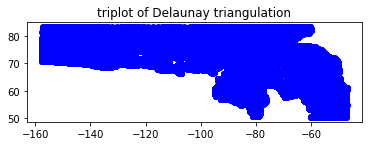

In [21]:
import matplotlib.tri as tri
# Create the Triangulation; no triangles so Delaunay triangulation created.
triang = tri.Triangulation(xflowem, yflowem)

max_radius = 2
triangles = triang.triangles
# Mask off unwanted triangles.
xtri = xflowem[triangles] - np.roll(xflowem[triangles], 1, axis=1)
ytri = yflowem[triangles] - np.roll(yflowem[triangles], 1, axis=1)
maxi = np.max(np.sqrt(xtri**2 + ytri**2), axis=1)
triang.set_mask(maxi > max_radius)

#another way to do is transform x,y _

# x, y, _= proj.transform_points(ccrs.PlateCarree(), xflowem, yflowem).T
#masking not required in this case,
# mask = np.invert(np.logical_or(np.isinf(x), np.isinf(y)))
# x = np.compress(mask, x)
# y = np.compress(mask, y)
fig1, ax1 = plt.subplots()
ax1.set_aspect('equal')
ax1.triplot(triang, 'bo-', lw=1)
ax1.set_title('triplot of Delaunay triangulation')


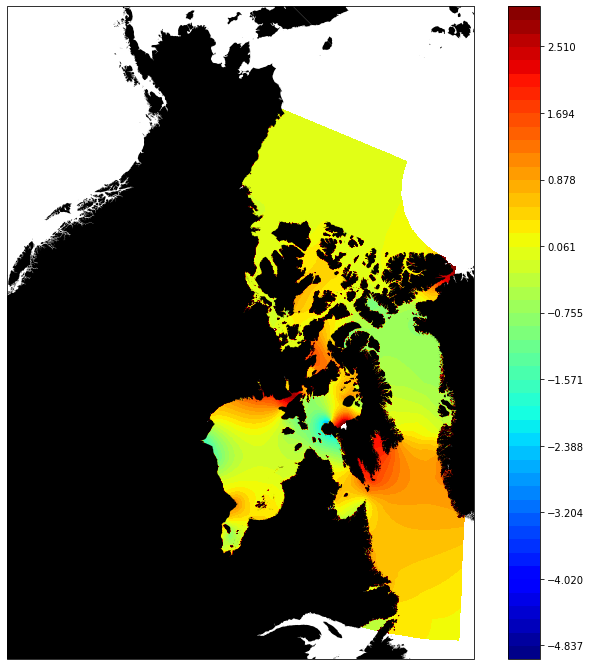

In [25]:
proj=ccrs.NorthPolarStereo(central_longitude=-45.0,true_scale_latitude=None, globe=None)
fig=plt.figure(figsize=(12, 12), frameon=True)

ax1=fig.add_subplot(1,1,1,projection=proj) 
ax1.set_extent((-158, -47, 49, 84), crs=ccrs.PlateCarree())
feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='black',alpha=1,edgecolor='none')
ax1.add_feature(feature)
cont=ax1.tricontourf(triang,hflowem[1,:],levels=np.linspace(-5,3,50),cmap='jet',transform=ccrs.PlateCarree())
fig.colorbar(cont)
# ax1.triplot(triang, 'bo-', lw=1,transform=ccrs.PlateCarree())
# ax1.set_title('triplot of Delaunay triangulation')
fig.savefig('waterlevel_0.jpg')

In [3]:
from scipy.interpolate import griddata
lonmin=xflowem.min();lonmax=xflowem.max()
print(lonmin,lonmax)
latmin=yflowem.min();latmax=yflowem.max()
print(latmin,latmax)
lonvec=np.linspace(lonmin,lonmax,200);latvec=np.linspace(latmin,latmax,150)
longrid,latgrid=np.meshgrid(lonvec,latvec)


-157.47847604721045 -47.1376845836692
50.40526975889424 83.18846244907004


In [10]:
i=2
ugrid=griddata((xflowem,yflowem),uflowem[i,:],(longrid,latgrid),method='linear',fill_value=np.nan)
vgrid=griddata((xflowem,yflowem),vflowem[i,:],(longrid,latgrid),method='linear',fill_value=np.nan)
colors=np.sqrt(ugrid**2+vgrid**2)
colors.shape

(150, 200)

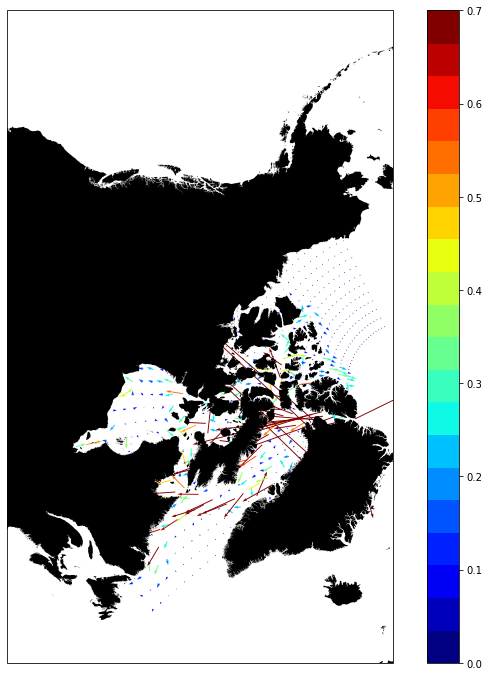

In [11]:
proj=ccrs.NorthPolarStereo(central_longitude=0.0,true_scale_latitude=None, globe=None)
skip=(slice(None,None,5),slice(None,None,5))
norm = mcolors.Normalize(vmin=0.,vmax=0.7,clip=False)
cmap = mcolors.ListedColormap(plt.cm.jet(np.linspace(0,1,20)), "name")
# norm.autoscale(colors)
# colormap=cm.jet
# x, y, _= proj.transform_points(ccrs.PlateCarree(), xflowem, yflowem).T
# mask = np.invert(np.logical_or(np.isinf(x), np.isinf(y)))
# x = np.compress(mask, x)
# y = np.compress(mask, y)
fig=plt.figure(figsize=(12, 12), frameon=True)

ax1=fig.add_subplot(1,1,1,projection=proj) 
ax1.set_extent((-158, -47, 45, 84), crs=ccrs.PlateCarree())
feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='black',alpha=1,edgecolor='none')
ax1.add_feature(feature)
# cont=ax1.contourf(longrid,latgrid,valuegrid,levels=np.linspace(-5,3,50),cmap='jet',transform=ccrs.PlateCarree())
quiv=ax1.quiver(longrid[skip],latgrid[skip],ugrid[skip],vgrid[skip],colors[skip],transform=ccrs.PlateCarree(),units='xy',cmap=cmap,norm=norm,scale_units='width')
# stream=ax1.streamplot(longrid[skip],latgrid[skip],ugrid[skip],vgrid[skip],cmap='jet',transform=ccrs.PlateCarree())
fig.colorbar(quiv)
fig.savefig('velocity_'+str(i)+'.jpg',dpi=1000)

In [12]:
print(ugrid[:,1])
print(vgrid[:,2])

[            nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan         

In [21]:
print(longrid[:,0])
print(latgrid[:,0])

[-157.47847605 -157.47847605 -157.47847605 -157.47847605 -157.47847605
 -157.47847605 -157.47847605 -157.47847605 -157.47847605 -157.47847605
 -157.47847605 -157.47847605 -157.47847605 -157.47847605 -157.47847605
 -157.47847605 -157.47847605 -157.47847605 -157.47847605 -157.47847605
 -157.47847605 -157.47847605 -157.47847605 -157.47847605 -157.47847605
 -157.47847605 -157.47847605 -157.47847605 -157.47847605 -157.47847605
 -157.47847605 -157.47847605 -157.47847605 -157.47847605 -157.47847605
 -157.47847605 -157.47847605 -157.47847605 -157.47847605 -157.47847605
 -157.47847605 -157.47847605 -157.47847605 -157.47847605 -157.47847605
 -157.47847605 -157.47847605 -157.47847605 -157.47847605 -157.47847605
 -157.47847605 -157.47847605 -157.47847605 -157.47847605 -157.47847605
 -157.47847605 -157.47847605 -157.47847605 -157.47847605 -157.47847605
 -157.47847605 -157.47847605 -157.47847605 -157.47847605 -157.47847605
 -157.47847605 -157.47847605 -157.47847605 -157.47847605 -157.47847605
 -157.